In [1]:
import os
import numpy as np
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from pyspark.sql.functions import udf
from pyspark.sql.types import *
from pyspark.ml.feature import StringIndexer
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.util import MLUtils
from pyspark.ml.linalg import Matrices
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import IndexToString, StringIndexer, VectorIndexer
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

In [2]:
# Calling spark session to register application
spark = SparkSession \
    .builder \
    .appName("Random") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

In [3]:
train_df = spark.read \
    .format("csv") \
    .option("header", "true") \
    .option("inferSchema", "true") \
    .load("train.csv")

In [4]:
#Read csv file into pyspark dataframe
train_df.show(10)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
|          6|       0|     3|    Moran, Mr. James|  male|null|    0|    0|      

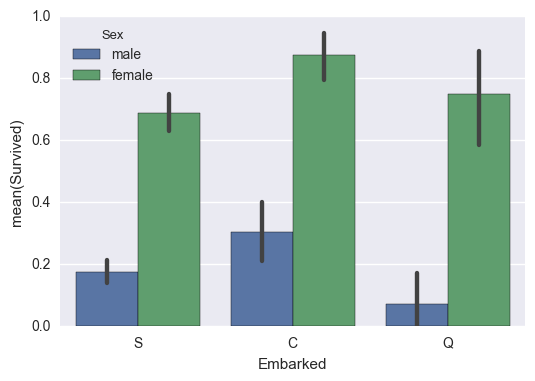

In [5]:
# Visualizing data is crucial for recognizing underlying patterns to exploit in the model.
sns.barplot(x="Embarked", y="Survived", hue="Sex", data=train_df.toPandas())

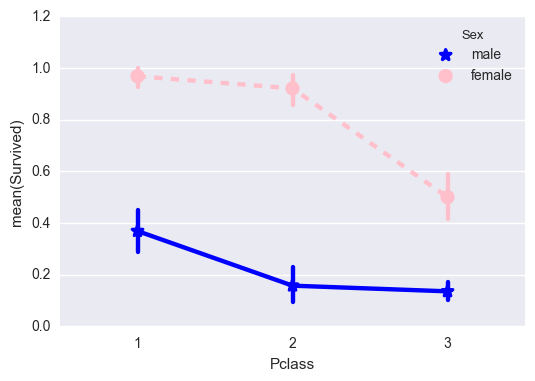

In [6]:
sns.pointplot(x="Pclass", y="Survived", hue="Sex", data=train_df.toPandas(),
              palette={"male": "blue", "female": "pink"},
              markers=["*", "o"], linestyles=["-", "--"]);

In [7]:
##
## Transforming Features
#
#   1. Aside from 'Sex', the 'Age' feature is second in importance. 
#     To avoid overfitting, I'm grouping people into logical human age groups.
#
#   2. Each Cabin starts with a letter. I bet this letter is much more important than the number that follows, 
#     let's slice it off.
#    
#   3. Fare is another continuous value that should be simplified. Place them into quartile bins accordingly.
#    
#   4. Extract information from the 'Name' feature. Rather than use the full name, I extracted the last name 
#      and name prefix (Mr. Mrs. Etc.), then appended them as their own features.
#      Lastly, drop useless features. (Ticket and Name)


def ageToCategory(age):
    if age <= -1: return 'Unknown'
    elif age > -1 and age <= 0: return 'Baby'
    elif age > 0 and age <= 5: return 'Child'
    elif age > 5 and age <= 18: return 'Teenager'
    elif age > 18 and age <= 25: return 'Student'
    elif age > 25 and age <= 35: return 'Young Adult'
    elif age > 35 and age <= 60: return 'Adult'
    elif age > 60 and age <= 120: return 'Senior'
udfAgeToCategory = udf(ageToCategory, StringType())

In [8]:
#df = df.select("Age", udfAgeToCategory("Age").alias("LabelAge"))
train_df = train_df.withColumn("Age", udfAgeToCategory("Age"))

In [9]:
def simpleCabin(x):
    if x is None:return 'N'
    else:return x[0]
udfSimpleCabin = udf(simpleCabin,StringType())

In [10]:
train_df = train_df.withColumn("Cabin",udfSimpleCabin("Cabin"))

In [11]:
train_df.na.fill({'Fare':-0.5})
def simpleFares(fare):
    if fare <= -1:return 'Unknown'
    elif fare > -1 and fare <= 0:return '1_quartile'
    elif fare > 0 and fare <= 8:return '2_quartile'
    elif fare > 8 and fare <= 15:return '3_quartile'
    elif fare > 15 and fare <= 31:return '4_quartile'
    elif fare > 31 and fare <= 1000:return '5_quartile'
udfSimpleFares = udf(simpleFares,StringType())

In [12]:
train_df = train_df.withColumn("Fare",udfSimpleFares("Fare"))

In [13]:
def FetchLastName(name):
    return name.split(' ')[0]
def FetchSal(name):
    return name.split(' ')[1]
udfFetchLastName = udf(FetchLastName,StringType())
udfFetchSal = udf(FetchSal,StringType())

train_df = train_df.withColumn("Last Name",udfFetchLastName("Name"))
train_df = train_df.withColumn("Prefix",udfFetchSal("Name"))

In [14]:
train_df.show(5)

+-----------+--------+------+--------------------+------+-----------+-----+-----+----------------+----------+-----+--------+----------+------+
|PassengerId|Survived|Pclass|                Name|   Sex|        Age|SibSp|Parch|          Ticket|      Fare|Cabin|Embarked| Last Name|Prefix|
+-----------+--------+------+--------------------+------+-----------+-----+-----+----------------+----------+-----+--------+----------+------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|    Student|    1|    0|       A/5 21171|2_quartile|    N|       S|   Braund,|   Mr.|
|          2|       1|     1|Cumings, Mrs. Joh...|female|      Adult|    1|    0|        PC 17599|5_quartile|    C|       C|  Cumings,|  Mrs.|
|          3|       1|     3|Heikkinen, Miss. ...|female|Young Adult|    0|    0|STON/O2. 3101282|2_quartile|    N|       S|Heikkinen,| Miss.|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|Young Adult|    1|    0|          113803|5_quartile|    C|       S| Futrelle,|  Mrs.|

In [15]:
train_df = train_df.drop('Name','Ticket','Last Name','Embarked')

In [16]:
train_df.show(5)

+-----------+--------+------+------+-----------+-----+-----+----------+-----+------+
|PassengerId|Survived|Pclass|   Sex|        Age|SibSp|Parch|      Fare|Cabin|Prefix|
+-----------+--------+------+------+-----------+-----+-----+----------+-----+------+
|          1|       0|     3|  male|    Student|    1|    0|2_quartile|    N|   Mr.|
|          2|       1|     1|female|      Adult|    1|    0|5_quartile|    C|  Mrs.|
|          3|       1|     3|female|Young Adult|    0|    0|2_quartile|    N| Miss.|
|          4|       1|     1|female|Young Adult|    1|    0|5_quartile|    C|  Mrs.|
|          5|       0|     3|  male|Young Adult|    0|    0|3_quartile|    N|   Mr.|
+-----------+--------+------+------+-----------+-----+-----+----------+-----+------+
only showing top 5 rows



In [17]:
features = ['Fare', 'Cabin', 'Age', 'Sex','Prefix']
for feature in features:
    indexer = StringIndexer(inputCol = feature, outputCol = feature+'_Transformed')
    train_df = indexer.fit(train_df).transform(train_df)
    train_df = train_df.drop(feature)


In [18]:
train_df.show(5)

+-----------+--------+------+-----+-----+----------------+-----------------+---------------+---------------+------------------+
|PassengerId|Survived|Pclass|SibSp|Parch|Fare_Transformed|Cabin_Transformed|Age_Transformed|Sex_Transformed|Prefix_Transformed|
+-----------+--------+------+-----+-----+----------------+-----------------+---------------+---------------+------------------+
|          1|       0|     3|    1|    0|             0.0|              0.0|            3.0|            0.0|               0.0|
|          2|       1|     1|    1|    0|             1.0|              1.0|            1.0|            1.0|               2.0|
|          3|       1|     3|    0|    0|             0.0|              0.0|            0.0|            1.0|               1.0|
|          4|       1|     1|    1|    0|             1.0|              1.0|            0.0|            1.0|               2.0|
|          5|       0|     3|    0|    0|             2.0|              0.0|            0.0|            

In [19]:
# Index labels, adding metadata to the label column.
# Fit on whole dataset to include all labels in index.
labelIndexer = StringIndexer(inputCol="Survived", outputCol="indexedLabel").fit(train_df)

# Automatically identify categorical features, and index them.
# Set maxCategories so features with > 4 distinct values are treated as continuous.
featureIndexer =\
    VectorAssembler(
    inputCols=['Pclass','SibSp','Parch','Fare_Transformed','Cabin_Transformed','Age_Transformed','Sex_Transformed','Prefix_Transformed'],
    outputCol="features")

In [20]:
(trainingData, testData) = train_df.randomSplit([0.7, 0.3])

In [21]:
# Train a RandomForest model.
rf = RandomForestClassifier(labelCol="indexedLabel", featuresCol="features", numTrees=300)

# Convert indexed labels back to original labels.
labelConverter = IndexToString(inputCol="prediction", outputCol="predictedLabel",
                               labels=labelIndexer.labels)
# Chain indexers and forest in a Pipeline
pipeline = Pipeline(stages=[labelIndexer, featureIndexer, rf, labelConverter])


In [22]:
# Train model.  This also runs the indexers.
model = pipeline.fit(trainingData)


In [23]:
predictions = model.transform(testData)
predictions.select("predictedLabel","Survived", "features").show(5)

+--------------+--------+--------------------+
|predictedLabel|Survived|            features|
+--------------+--------+--------------------+
|             0|       0|(8,[0,1,5],[3.0,1...|
|             1|       1|[1.0,1.0,0.0,1.0,...|
|             1|       1|[1.0,1.0,0.0,1.0,...|
|             0|       0| (8,[0,3],[3.0,2.0])|
|             1|       0|(8,[0,3,4,5],[1.0...|
+--------------+--------+--------------------+
only showing top 5 rows



In [24]:
evaluator = MulticlassClassificationEvaluator(
    labelCol="indexedLabel", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)
print("Accuracy = %g"%accuracy)
print("Test Error = %g" % (1.0 - accuracy))

Accuracy = 0.84739
Test Error = 0.15261


In [25]:
rfModel = model.stages[2]
print(rfModel) 

RandomForestClassificationModel (uid=rfc_6aa1dbe35211) with 300 trees


In [26]:
rfModel.trees

[DecisionTreeClassificationModel (uid=dtc_b1aed17fe1cd) of depth 5 with 47 nodes,
 DecisionTreeClassificationModel (uid=dtc_4283c554954b) of depth 5 with 41 nodes,
 DecisionTreeClassificationModel (uid=dtc_76db93eeebb7) of depth 5 with 41 nodes,
 DecisionTreeClassificationModel (uid=dtc_5da3732a3ffb) of depth 5 with 49 nodes,
 DecisionTreeClassificationModel (uid=dtc_756d3c630d9d) of depth 5 with 45 nodes,
 DecisionTreeClassificationModel (uid=dtc_7c67f7d1ea6e) of depth 5 with 55 nodes,
 DecisionTreeClassificationModel (uid=dtc_d6b37e5edae6) of depth 5 with 49 nodes,
 DecisionTreeClassificationModel (uid=dtc_7c439954cef0) of depth 5 with 47 nodes,
 DecisionTreeClassificationModel (uid=dtc_6cb4aae06d46) of depth 5 with 51 nodes,
 DecisionTreeClassificationModel (uid=dtc_bd0a6887d1ed) of depth 5 with 35 nodes,
 DecisionTreeClassificationModel (uid=dtc_7af1ac05cf0a) of depth 5 with 51 nodes,
 DecisionTreeClassificationModel (uid=dtc_b19a8e410dde) of depth 5 with 45 nodes,
 DecisionTreeCla